<a href="https://colab.research.google.com/github/Iampegassi/MasterClass_MetaPhysics/blob/main/Facial_expression_classification_analysis10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Path to train and test CSV files
original_train_csv_path = '/content/drive/My Drive/facial_expression_dataset/train_labels.csv'
original_test_csv_path = '/content/drive/My Drive/facial_expression_dataset/test_labels.csv'

# Load train and test CSV files
train_df = pd.read_csv(original_train_csv_path)
test_df = pd.read_csv(original_test_csv_path)

In [4]:
import pandas as pd
import numpy as np
import random

# Path to original train and test CSV files
original_train_csv_path = '/content/drive/My Drive/facial_expression_dataset/train_labels.csv'
original_test_csv_path = '/content/drive/My Drive/facial_expression_dataset/test_labels.csv'

# Path to new shuffled train and test CSV files
train_csv_path = '/content/drive/My Drive/facial_expression_dataset/train_labels_shuffled.csv'
test_csv_path = '/content/drive/My Drive/facial_expression_dataset/test_labels_shuffled.csv'

# Load original train and test CSV files
train_df = pd.read_csv(original_train_csv_path)
test_df = pd.read_csv(original_test_csv_path)

# Set random seed for reproducibility
np.random.seed(42)

# Randomly select 50% of the data from the train and test datasets
train_df = train_df.sample(frac=0.5, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=0.5, random_state=42).reset_index(drop=True)

# Save the new shuffled train and test datasets to CSV files
train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print("New shuffled datasets created and saved successfully.")


New shuffled datasets created and saved successfully.


Random images from train dataframe:


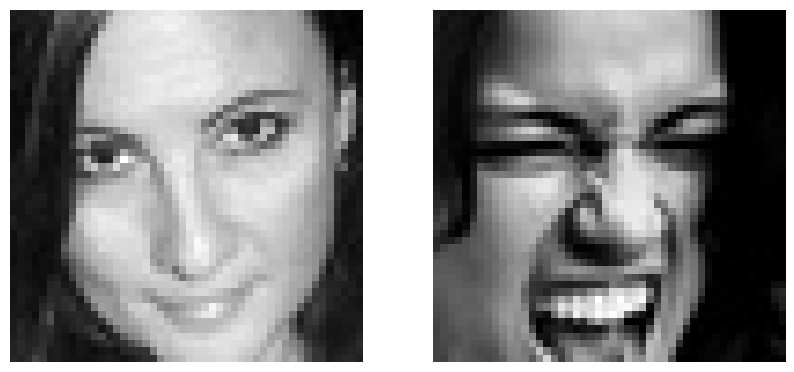

Random images from test dataframe:


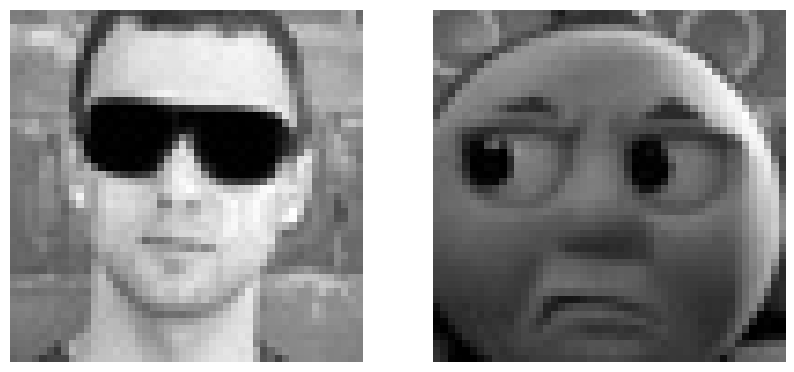

In [5]:
# Path to train and test CSV files
train_csv_path = '/content/drive/My Drive/facial_expression_dataset/train_labels_shuffled.csv'
test_csv_path = '/content/drive/My Drive/facial_expression_dataset/test_labels_shuffled.csv'

# Load train and test CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Function to display random images horizontally
def display_random_images(dataframe):
    # Get two random indices
    random_indices = random.sample(range(len(dataframe)), 2)
    # Load and display images horizontally
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for i, ax in enumerate(axes):
        image_path = dataframe.iloc[random_indices[i]]['image_path']
        image = plt.imread(image_path)
        ax.imshow(image, cmap='gray')  # Display grayscale image
        ax.axis('off')
    plt.show()

# Display random images from train dataframe
print("Random images from train dataframe:")
display_random_images(train_df)

# Display random images from test dataframe
print("Random images from test dataframe:")
display_random_images(test_df)

PRE-PROCESSING

In [5]:
# Print size and shape of train and test dataframes
print("Train dataframe size:", len(train_df))
print("Train dataframe shape:", train_df.shape)
print("\nTest dataframe size:", len(test_df))
print("Test dataframe shape:", test_df.shape)

Train dataframe size: 14410
Train dataframe shape: (14410, 2)

Test dataframe size: 3533
Test dataframe shape: (3533, 2)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Displaying augmented images with labels:


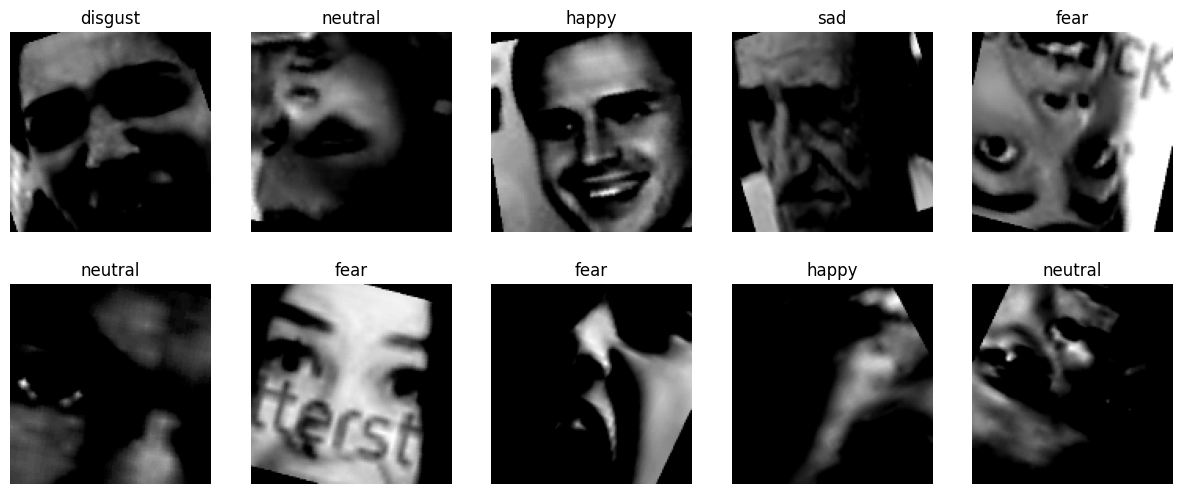


Unique labels in train dataset: ['sad' 'neutral' 'happy' 'fear' 'surprise' 'angry' 'disgust']
Unique labels in test dataset: ['neutral' 'happy' 'surprise' 'sad' 'disgust' 'fear' 'angry']


In [6]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load train and test CSV files
train_csv_path = '/content/drive/My Drive/facial_expression_dataset/train_labels_shuffled.csv'
test_csv_path = '/content/drive/My Drive/facial_expression_dataset/test_labels_shuffled.csv'
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

from PIL import Image
import torchvision.transforms as transforms

def load_image(image_path):
    # Open the image file
    image = Image.open(image_path)
    # Apply transformations to convert the image to a tensor
    transform = transforms.Compose([
        transforms.ToTensor(),
        # Add other transformations as needed
    ])
    image = transform(image)
    return image


class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        # Load image and label from your data
        img_path = self.data.iloc[index, 0]
        image = Image.open(img_path)  # Load image from file or other data source
        label = self.data.iloc[index, 1]  # Assuming label is stored in the second column

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.data)

# Define transformations for data augmentation and normalization
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),            # Resize and crop
    transforms.RandomRotation(degrees=30),        # Random rotation by up to 30 degrees
    transforms.RandomHorizontalFlip(p=0.5),      # Random horizontal flipping with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),        # Random vertical flipping with a probability of 0.5
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Random resized crop
    transforms.ColorJitter(brightness=0.1, contrast=0.0, saturation=0.2, hue=0.0),  # Random color jitter
    transforms.ToTensor(),                        # Convert PIL image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize to [-1, 1] range
])

test_transform = transforms.Compose([
    transforms.Resize(256),                       # Resize
    transforms.CenterCrop(224),                   # Center crop
    transforms.ToTensor(),                        # Convert PIL image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize to [-1, 1] range
])

# Apply transformations to train and test datasets
train_dataset = CustomDataset(train_df, transform=train_transform)
test_dataset = CustomDataset(test_df, transform=test_transform)

# Encode labels
label_encoder = LabelEncoder()
train_df['label_encoded'] = label_encoder.fit_transform(train_df['label'])
test_df['label_encoded'] = label_encoder.transform(test_df['label'])

# Display augmented images with labels
def display_augmented_images(dataset):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(2):
        for j in range(5):
            idx = random.randint(0, len(dataset) - 1)
            image, label = dataset[idx]
            # Clip pixel values to [0, 1] range
            image = torch.clamp(image, 0, 1)
            image = image.permute(1, 2, 0)  # Convert (C, H, W) to (H, W, C) for displaying with matplotlib
            axes[i, j].imshow(image, cmap='gray')  # Specify colormap as gray for grayscale images
            axes[i, j].set_title(label)
            axes[i, j].axis('off')
    plt.show()

# Display augmented images with labels
print("Displaying augmented images with labels:")
display_augmented_images(train_dataset)

# Check if label mapping is needed
print("\nUnique labels in train dataset:", train_df['label'].unique())
print("Unique labels in test dataset:", test_df['label'].unique())



In [7]:
import pandas as pd
from PIL import Image

# Define paths to train and test CSV files
train_csv_path = '/content/drive/My Drive/facial_expression_dataset/train_labels_shuffled.csv'
test_csv_path = '/content/drive/My Drive/facial_expression_dataset/test_labels_shuffled.csv'

# Load train and test CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Select a single image path from train dataframe (assuming it's the first row)
train_image_path = train_df['image_path'].iloc[0] if 'image_path' in train_df.columns else None

# Select a single image path from test dataframe (assuming it's the first row)
test_image_path = test_df['image_path'].iloc[0] if 'image_path' in test_df.columns else None

def get_image_dimensions(img_path):
    try:
        img = Image.open(img_path)
        width, height = img.size
        return width, height
    except Exception as e:
        print(f"Error loading image from path '{img_path}': {str(e)}")
        return None

# Get dimensions of the single image from train dataframe
train_image_dimensions = get_image_dimensions(train_image_path) if train_image_path else None

# Get dimensions of the single image from test dataframe
test_image_dimensions = get_image_dimensions(test_image_path) if test_image_path else None

print("Dimensions of image in train dataframe:", train_image_dimensions)
print("Dimensions of image in test dataframe:", test_image_dimensions)




Dimensions of image in train dataframe: (48, 48)
Dimensions of image in test dataframe: (48, 48)


In [8]:
import torch
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms

# Define augmentation transform
augment_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),            # Resize and crop
    transforms.RandomHorizontalFlip(),            # Random horizontal flip
    transforms.GaussianBlur(kernel_size=3),       # Adjust kernel_size as needed
    transforms.ToTensor(),                        # Convert PIL image to tensor
    transforms.Normalize(mean=[0.4, 0.4, 0.4], std=[0.4, 0.4, 0.4])  # Adjust mean and std as needed
])

def custom_collate_fn(batch):
    images, class_labels, image_paths = zip(*batch)

    # Convert images to tensors and stack them
    images = torch.stack(images, dim=0)

    # Apply augmentation
    images = augment_transform(images)

    # Encode class labels into numerical labels
    label_encoder = LabelEncoder()
    numerical_labels = label_encoder.fit_transform(class_labels)

    # Convert numerical labels to a tensor
    labels = torch.tensor(numerical_labels)

    return images, labels, image_paths


In [9]:
import torch
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import time

# Define paths to train and test CSV files
train_csv_path = '/content/drive/My Drive/facial_expression_dataset/train_labels_shuffled.csv'
test_csv_path = '/content/drive/My Drive/facial_expression_dataset/test_labels_shuffled.csv'

# Load train and test CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Define custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.dataframe['label_encoded'] = self.label_encoder.fit_transform(self.dataframe['label'])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]  # Assuming first column contains image paths
        image = Image.open(img_path).convert("RGB")  # Ensure the image is in RGB format
        label = self.dataframe.iloc[idx, 1]  # Assuming second column contains labels
        label = self.label_encoder.transform([label])[0]  # Convert label to integer
        label = torch.tensor(label)  # Convert label to tensor

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations for data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),             # Resize images to (224, 224)
    transforms.RandomHorizontalFlip(),         # Random horizontal flip
    transforms.ToTensor(),                     # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),             # Resize images to (224, 224)
    transforms.ToTensor(),                     # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Create custom datasets
train_dataset = CustomDataset(train_df, transform=train_transform)
test_dataset = CustomDataset(test_df, transform=test_transform)

# Set up data loaders
batch_size = 32
num_workers = 0
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Print dataset information
print("\nDataset Information:")
print("Number of training samples:", len(train_dataset))
print("Number of test samples:", len(test_dataset))
print("Batch size:", batch_size)
print("Number of workers:", num_workers)

# Training loop with print statements
start_time = time.time()
for i, (images, labels) in enumerate(train_loader):
    print(f"Batch {i+1}")
    print(f"Images shape: {images.shape}")
    print("Labels:", labels)
    break

end_time = time.time()
print(f"Time taken to load the first batch: {end_time - start_time} seconds")





Dataset Information:
Number of training samples: 14410
Number of test samples: 3533
Batch size: 32
Number of workers: 0
Batch 1
Images shape: torch.Size([32, 3, 224, 224])
Labels: tensor([5, 3, 5, 5, 6, 4, 5, 5, 3, 2, 5, 0, 0, 4, 5, 0, 0, 2, 2, 6, 3, 0, 5, 4,
        6, 6, 6, 3, 0, 2, 3, 4])
Time taken to load the first batch: 21.993528842926025 seconds


MODEL ARCHITECTURE (CNN, RESNET, DENSENET)

In [10]:
import torch
import torch.nn as nn

# Define the device (GPU if available, otherwise CPU)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CNNModel(nn.Module):
    def __init__(self, num_classes=7):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
cnn_model = CNNModel(num_classes=7)

# Move the model to the appropriate device (GPU if available, otherwise CPU)
cnn_model.to(DEVICE)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.0003, momentum=0.9)

# Define the learning rate scheduler
gamma = 0.9
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)

# Define the number of epochs
num_epochs = 10

# Print device information
print(f"Using device: {DEVICE}")



Using device: cuda


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# Define the model
class conv3x3(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(conv3x3, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

    def forward(self, x):
        return self.conv(x)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=7):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def make_layer(self, block, out_channels, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the model
model = ResNet(BasicBlock, [2, 2, 2, 2])  # Example: ResNet18

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.0003, momentum=0.9)

# Define the learning rate scheduler
gamma = 0.9
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma)

# Define the number of epochs
num_epochs = 10

# Print device information
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Move the model to the appropriate device
model = model.to(DEVICE)


Using device: cuda


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        out = self.conv(self.relu(self.bn(x)))
        out = torch.cat([x, out], 1)
        return out

class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(DenseLayer(in_channels + i * growth_rate, growth_rate))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class TransitionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionBlock, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.pool = nn.AvgPool2d(2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.bn(x)))
        x = self.pool(x)
        return x

class DenseNet(nn.Module):
    def __init__(self, growth_rate=12, block_config=(6, 12, 24, 16), num_classes=7):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.features = self._make_dense_layers(block_config)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.in_channels, num_classes)

    def _make_dense_layers(self, block_config):
        layers = []
        for num_layers in block_config:
            layers.append(DenseBlock(self.in_channels, self.growth_rate, num_layers))
            self.in_channels += num_layers * self.growth_rate
            if num_layers != block_config[-1]:
                layers.append(TransitionBlock(self.in_channels, self.in_channels // 2))
                self.in_channels //= 2
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


# Initialize the DenseNet model
densenet_model = DenseNet()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the model
model = DenseNet()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.0003, momentum=0.9)

# Define the learning rate scheduler
gamma = 0.9
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma)

# Define the number of epochs
num_epochs = 10

# Print device information
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Move the model to the appropriate device
model = model.to(DEVICE)



Using device: cuda


TRAINING LOOP

In [17]:
!pip install tensorboardcolab

  Preparing metadata (setup.py) ... done
  Created wheel for tensorboardcolab: filename=tensorboardcolab-0.0.22-py3-none-any.whl size=3832 sha256=7c108af2e3c77d68a49939358752d3d6a28754034dc9b1ed26e9a26ea41baf48
  Stored in directory: /root/.cache/pip/wheels/8d/ee/46/7fe2bbbf1edbcfeabfaf13962dcaadec1f631d11147fd9d34d
Successfully built tensorboardcolab


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, Normalize
from torchvision.models import resnet18
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset
from torchsummary import summary
from tqdm.auto import tqdm

# Define the device (GPU if available, otherwise CPU)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CNNModel(nn.Module):
    def __init__(self, num_classes=7):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Define the directory where you want to save the models
save_dir = '/content/drive/MyDrive/saved_CNNfacialexpression_model/'
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists

# Set up TensorBoard writer
writer = SummaryWriter()

# Initialize variables for early stopping
best_loss = float('inf')
patience = 3
counter = 0

# Define the batch size
batch_size = 32

# Create a DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    cnn_model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    print(f'Epoch [{epoch + 1}/{num_epochs}]')  # Print epoch count

    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} [Training]', leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)  # Move data to the appropriate device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = cnn_model(images)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = 100 * correct / total

    # Print epoch results
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Save the model after each epoch
    torch.save(cnn_model.state_dict(), os.path.join(save_dir, f'cnn_model_epoch_{epoch + 1}.pt'))
    print(f'Saved model after epoch {epoch + 1}')

    # Update TensorBoard
    writer.add_scalar('Training Loss', epoch_loss, epoch + 1)
    writer.add_scalar('Training Accuracy', epoch_accuracy, epoch + 1)

    # Early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch + 1} due to no improvement in validation loss.')
            break

# Close the TensorBoard writer
writer.close()


Epoch [1/10]


Epoch 1/10 [Training]:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.0608, Accuracy: 15.57%
Saved model after epoch 1
Epoch [2/10]


Epoch 2/10 [Training]:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.0608, Accuracy: 15.73%
Saved model after epoch 2
Epoch [3/10]


Epoch 3/10 [Training]:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.0608, Accuracy: 15.75%
Saved model after epoch 3
Epoch [4/10]


Epoch 4/10 [Training]:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.0608, Accuracy: 15.73%
Saved model after epoch 4
Early stopping at epoch 4 due to no improvement in validation loss.


Epoch [1/10]


Epoch 1/10 [Training]:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.0559, Accuracy: 25.75%
Saved model after epoch 1
Epoch [2/10]


Epoch 2/10 [Training]:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.0534, Accuracy: 30.80%
Saved model after epoch 2
Epoch [3/10]


Epoch 3/10 [Training]:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.0493, Accuracy: 38.56%
Saved model after epoch 3
Epoch [4/10]


Epoch 4/10 [Training]:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.0453, Accuracy: 44.21%
Saved model after epoch 4
Epoch [5/10]


Epoch 5/10 [Training]:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.0421, Accuracy: 49.20%
Saved model after epoch 5
Epoch [6/10]


Epoch 6/10 [Training]:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.0400, Accuracy: 51.69%
Saved model after epoch 6
Epoch [7/10]


Epoch 7/10 [Training]:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.0378, Accuracy: 54.82%
Saved model after epoch 7
Epoch [8/10]


Epoch 8/10 [Training]:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.0355, Accuracy: 57.40%
Saved model after epoch 8
Epoch [9/10]


Epoch 9/10 [Training]:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.0333, Accuracy: 60.60%
Saved model after epoch 9
Epoch [10/10]


Epoch 10/10 [Training]:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.0309, Accuracy: 63.59%
Saved model after epoch 10


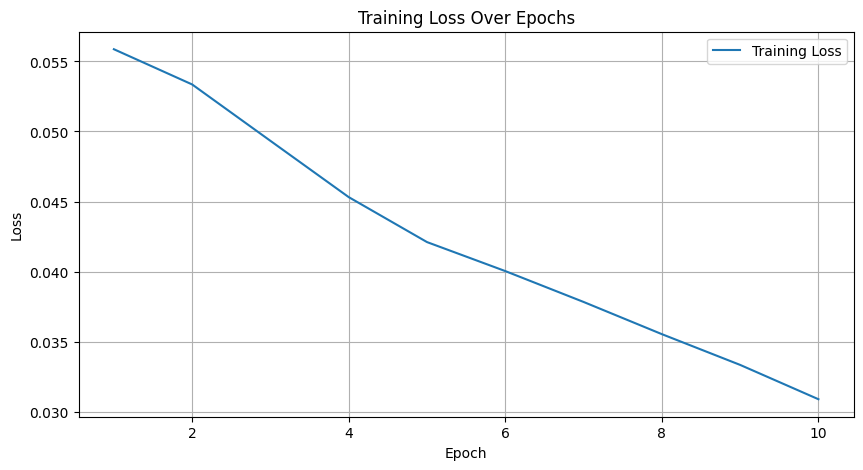

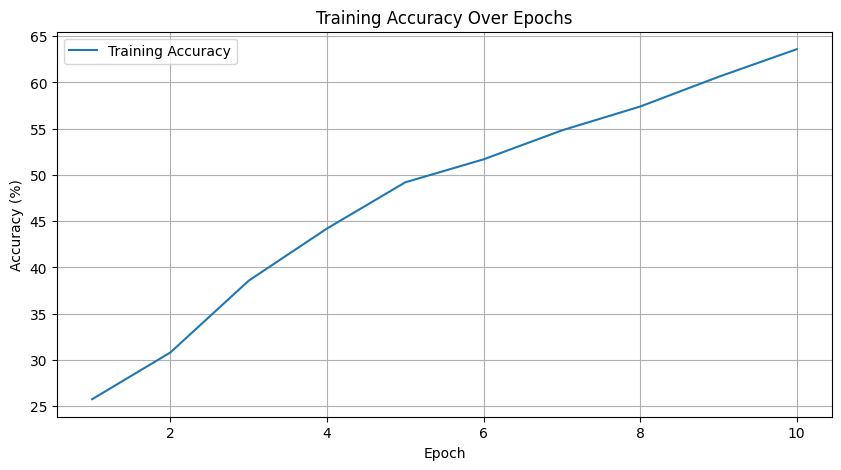

In [21]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, Normalize
from torchvision.models import resnet18
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset
from torchsummary import summary
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Define lists to store training loss and accuracy for each epoch
train_losses = []
train_accuracies = []

# Define the device (GPU if available, otherwise CPU)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Define the model
class conv3x3(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(conv3x3, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

    def forward(self, x):
        return self.conv(x)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=7):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def make_layer(self, block, out_channels, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the model
model = ResNet(BasicBlock, [2, 2, 2, 2]).to(DEVICE)

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.0003, momentum=0.9)

# Define the number of epochs
num_epochs = 10

# Define the directory where you want to save the models
save_dir = '/content/drive/MyDrive/saved_ResNetfacialexpression_model/'
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists

# Set up TensorBoard writer
writer = SummaryWriter()

# Initialize variables for early stopping
best_loss = float('inf')
patience = 3
counter = 0

# Define the batch size
batch_size = 32

# Create a DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    print(f'Epoch [{epoch + 1}/{num_epochs}]')  # Print epoch count

    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} [Training]', leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)  # Move data to the appropriate device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = 100 * correct / total

    # Append loss and accuracy to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Print epoch results
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Save the model after each epoch
    torch.save(model.state_dict(), os.path.join(save_dir, f'resnet_model_epoch_{epoch + 1}.pt'))
    print(f'Saved model after epoch {epoch + 1}')

    # Update TensorBoard
    writer.add_scalar('Training Loss', epoch_loss, epoch + 1)
    writer.add_scalar('Training Accuracy', epoch_accuracy, epoch + 1)

    # Early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch + 1} due to no improvement in validation loss.')
            break


# Close the TensorBoard writer
writer.close()

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Epoch [1/10]


Epoch 1/10 [Training]:   0%|          | 0/451 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/10], Loss: 1.7969, Accuracy: 25.05%
Saved model after epoch 1
Epoch [2/10]


Epoch 2/10 [Training]:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch [2/10], Loss: 1.7547, Accuracy: 27.70%
Saved model after epoch 2
Epoch [3/10]


Epoch 3/10 [Training]:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch [3/10], Loss: 1.7003, Accuracy: 31.26%
Saved model after epoch 3
Epoch [4/10]


Epoch 4/10 [Training]:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch [4/10], Loss: 1.6169, Accuracy: 35.95%
Saved model after epoch 4
Epoch [5/10]


Epoch 5/10 [Training]:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch [5/10], Loss: 1.5170, Accuracy: 40.56%
Saved model after epoch 5
Epoch [6/10]


Epoch 6/10 [Training]:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch [6/10], Loss: 1.4435, Accuracy: 44.04%
Saved model after epoch 6
Epoch [7/10]


Epoch 7/10 [Training]:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch [7/10], Loss: 1.3914, Accuracy: 46.18%
Saved model after epoch 7
Epoch [8/10]


Epoch 8/10 [Training]:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch [8/10], Loss: 1.3349, Accuracy: 47.93%
Saved model after epoch 8
Epoch [9/10]


Epoch 9/10 [Training]:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch [9/10], Loss: 1.2960, Accuracy: 49.93%
Saved model after epoch 9
Epoch [10/10]


Epoch 10/10 [Training]:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch [10/10], Loss: 1.2596, Accuracy: 51.76%
Saved model after epoch 10


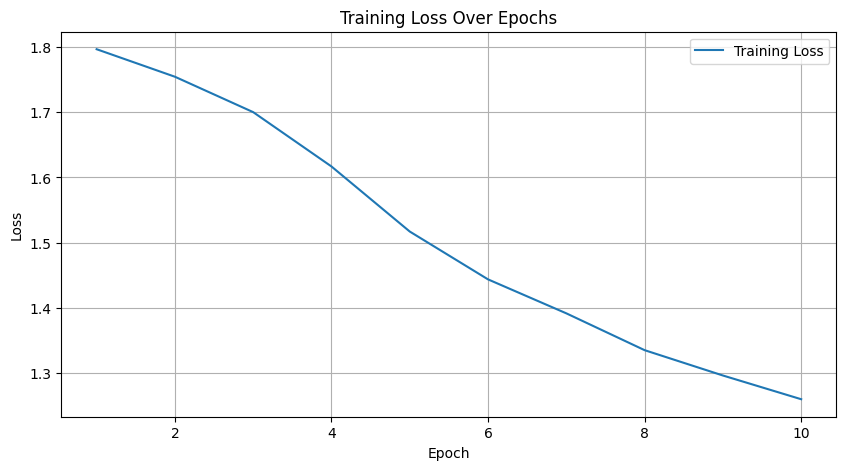

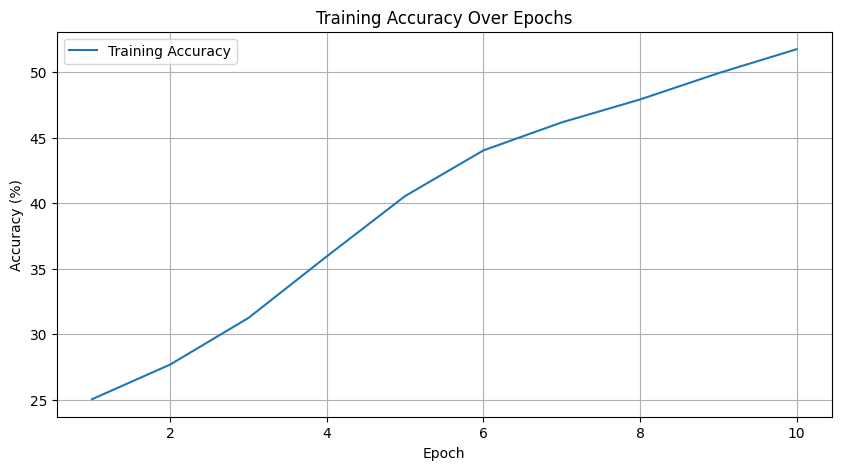

In [20]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Assuming the dataset, train_dataset, and val_dataset are already defined in a previous cell

# Define the device (GPU if available, otherwise CPU)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define DenseNet model components
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        out = self.conv(self.relu(self.bn(x)))
        out = torch.cat([x, out], 1)
        return out

class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(DenseLayer(in_channels + i * growth_rate, growth_rate))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class TransitionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionBlock, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.pool = nn.AvgPool2d(2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.bn(x)))
        x = self.pool(x)
        return x

class DenseNet(nn.Module):
    def __init__(self, growth_rate=12, block_config=(6, 12, 24, 16), num_classes=7):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.features = self._make_dense_layers(block_config)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.in_channels, num_classes)

    def _make_dense_layers(self, block_config):
        layers = []
        for num_layers in block_config:
            layers.append(DenseBlock(self.in_channels, self.growth_rate, num_layers))
            self.in_channels += num_layers * self.growth_rate
            if num_layers != block_config[-1]:
                layers.append(TransitionBlock(self.in_channels, self.in_channels // 2))
                self.in_channels //= 2
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Define the model
model = DenseNet().to(DEVICE)

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.0003, momentum=0.9)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the number of epochs
num_epochs = 10

# Define the directory where you want to save the models
save_dir = '/content/drive/MyDrive/saved_DensNetfacialexpression_model/'
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists

# Set up TensorBoard writer
writer = SummaryWriter()

# Initialize variables for early stopping
best_loss = float('inf')
patience = 3
counter = 0

# Define the batch size
batch_size = 32

# Create DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define lists to store training loss and accuracy for each epoch
train_losses = []
train_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    print(f'Epoch [{epoch + 1}/{num_epochs}]')  # Print epoch count

    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} [Training]', leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)  # Move data to the appropriate device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    # Append loss and accuracy to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Print epoch results
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Save the model after each epoch
    torch.save(model.state_dict(), os.path.join(save_dir, f'densnet_model_epoch_{epoch + 1}.pt'))
    print(f'Saved model after epoch {epoch + 1}')

    # Update TensorBoard
    writer.add_scalar('Training Loss', epoch_loss, epoch + 1)
    writer.add_scalar('Training Accuracy', epoch_accuracy, epoch + 1)

    # Early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch + 1} due to no improvement in validation loss.')
            break

# Close the TensorBoard writer
writer.close()

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


TESTING LOOP

Testing:   0%|          | 0/111 [00:00<?, ?it/s]

Test results saved to: /content/drive/MyDrive/cnn_model_test_results.csv


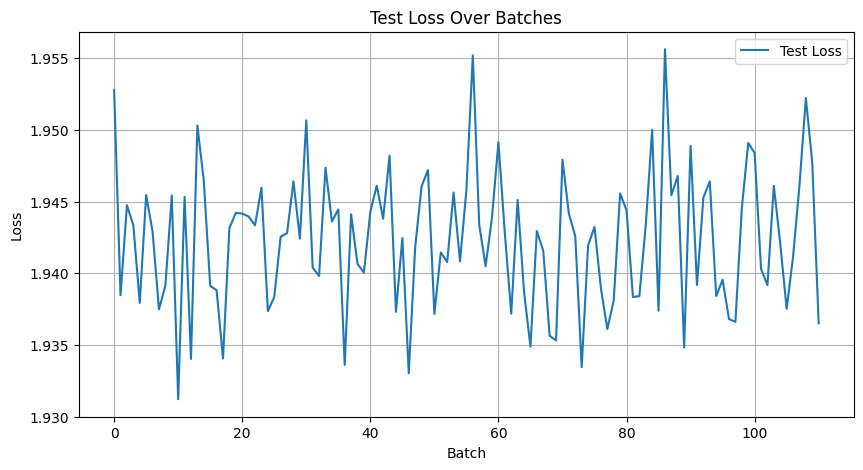

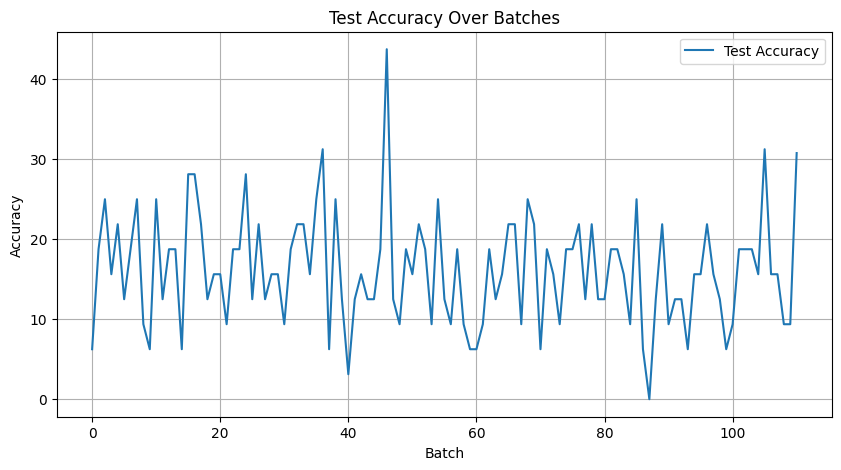

Average Test Loss: 1.9424
Average Test Accuracy: 16.13%


In [15]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Define lists to store test loss and accuracy for each batch
test_losses = []
test_accuracies = []

# Define the device (GPU if available, otherwise CPU)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the saved CNN model
saved_model_path = '/content/drive/MyDrive/saved_CNNfacialexpression_model/cnn_model_epoch_4.pt'
cnn_model = CNNModel(num_classes=7)
cnn_model.load_state_dict(torch.load(saved_model_path))
cnn_model.to(DEVICE)
cnn_model.eval()


# Create a DataLoader for the testing dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize lists to store predictions, true labels, and model outputs
predictions_list = []
true_labels_list = []
model_outputs_list = []

# Disable gradient computation during evaluation
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing', leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Forward pass
        outputs = cnn_model(images)

        # Calculate test loss
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())

        # Calculate test accuracy
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        accuracy = correct / total * 100
        test_accuracies.append(accuracy)

        # Save predictions, true labels, and model outputs
        predictions_list.extend(predicted.cpu().numpy())
        true_labels_list.extend(labels.cpu().numpy())
        model_outputs_list.extend(outputs.cpu().numpy())

# Create a DataFrame to store the information
df = pd.DataFrame({
    'Predictions': predictions_list,
    'True Labels': true_labels_list,
    'Model Outputs': model_outputs_list
})

# Save the DataFrame to a CSV file
csv_file_path = '/content/drive/MyDrive/cnn_model_test_results.csv'
df.to_csv(csv_file_path, index=False)

print('Test results saved to:', csv_file_path)

# Plot test loss
plt.figure(figsize=(10, 5))
plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Test Loss Over Batches')
plt.legend()
plt.grid(True)
plt.show()

# Plot test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(len(test_accuracies)), test_accuracies, label='Test Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Batches')
plt.legend()
plt.grid(True)
plt.show()

# Print average test loss and accuracy
average_test_loss = sum(test_losses) / len(test_losses)
average_test_accuracy = sum(test_accuracies) / len(test_accuracies)
print('Average Test Loss: {:.4f}'.format(average_test_loss))
print('Average Test Accuracy: {:.2f}%'.format(average_test_accuracy))


Testing:   0%|          | 0/111 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Test results saved to: /content/drive/MyDrive/resnet_model_test_results.csv
Average Test Loss: 1.3763
Average Test Accuracy: 50.46%


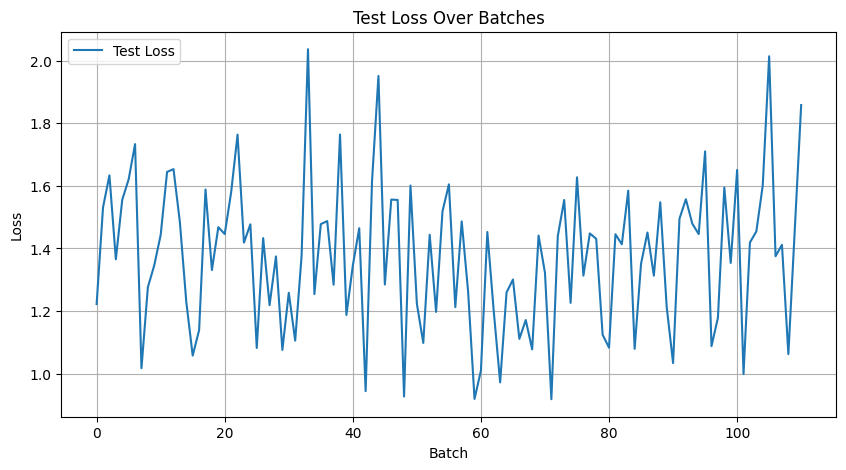

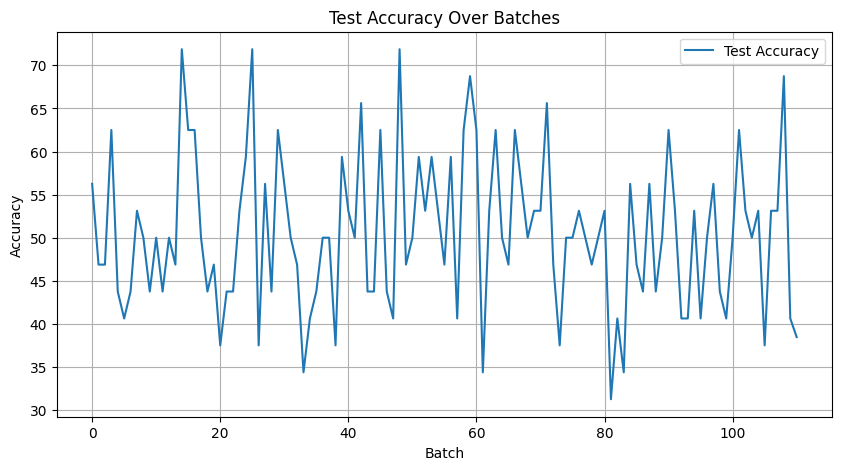

In [23]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Define the device (GPU if available, otherwise CPU)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the loss function (Assuming CrossEntropyLoss for classification)
criterion = torch.nn.CrossEntropyLoss()

# Define the model
model = ResNet(BasicBlock, [2, 2, 2, 2]).to(DEVICE)

# Load the saved ResNet model
saved_model_path = '/content/drive/MyDrive/saved_ResNetfacialexpression_model/resnet_model_epoch_10.pt'
model.load_state_dict(torch.load(saved_model_path, map_location=DEVICE))
model.eval()

# Create a DataLoader for the testing dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize lists to store predictions, true labels, and model outputs
predictions_list = []
true_labels_list = []
model_outputs_list = []

# Define lists to store test loss and accuracy for each batch
test_losses = []
test_accuracies = []

# Disable gradient computation during evaluation
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing', leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Forward pass
        outputs = model(images)

        # Calculate test loss
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())

        # Calculate test accuracy
        _, predicted = torch.max(outputs, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        accuracy = correct / total * 100
        test_accuracies.append(accuracy)

        # Save predictions, true labels, and model outputs
        predictions_list.extend(predicted.cpu().numpy())
        true_labels_list.extend(labels.cpu().numpy())
        model_outputs_list.extend(outputs.cpu().numpy())

# Create a DataFrame to store the information
df = pd.DataFrame({
    'Predictions': predictions_list,
    'True Labels': true_labels_list,
    'Model Outputs': model_outputs_list
})

# Save the DataFrame to a CSV file
csv_file_path = '/content/drive/MyDrive/resnet_model_test_results.csv'
df.to_csv(csv_file_path, index=False)

print('Test results saved to:', csv_file_path)

# Calculate and print average test loss and accuracy
average_test_loss = sum(test_losses) / len(test_losses)
average_test_accuracy = sum(test_accuracies) / len(test_accuracies)
print('Average Test Loss: {:.4f}'.format(average_test_loss))
print('Average Test Accuracy: {:.2f}%'.format(average_test_accuracy))

# Plot test loss
plt.figure(figsize=(10, 5))
plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Test Loss Over Batches')
plt.legend()
plt.grid(True)
plt.show()

# Plot test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(len(test_accuracies)), test_accuracies, label='Test Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Batches')
plt.legend()
plt.grid(True)
plt.show()


Testing:   0%|          | 0/111 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Test results saved to: /content/drive/MyDrive/desnse_model_test_results.csv


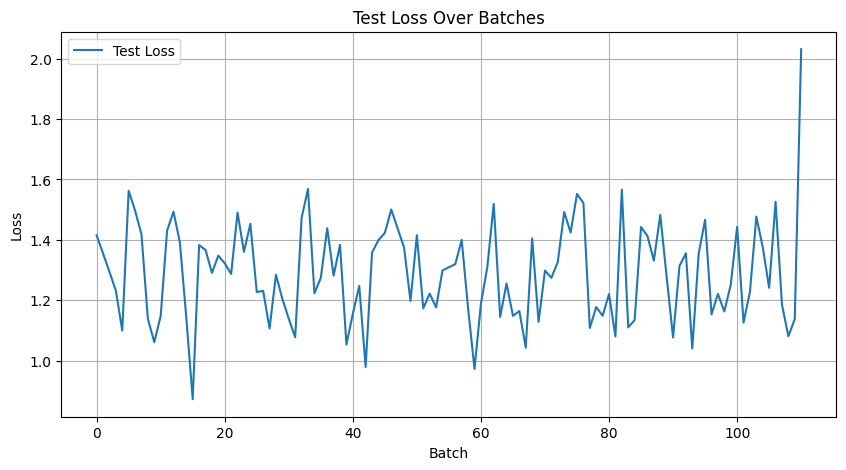

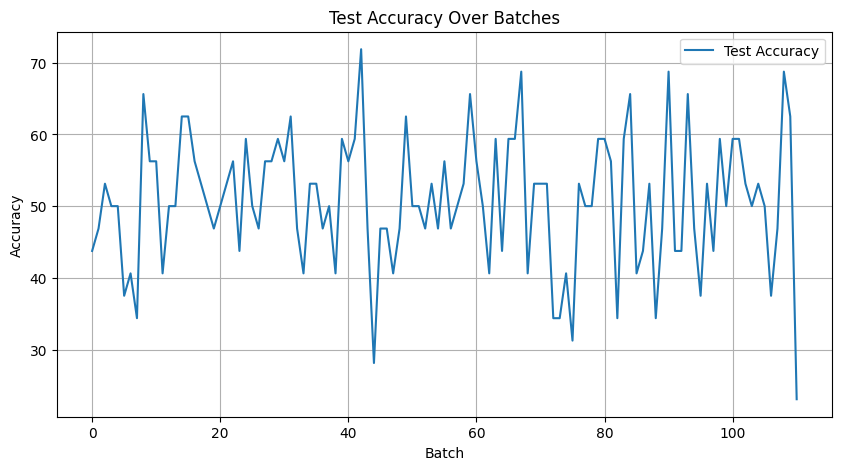

Average Test Loss: 1.2905
Average Test Accuracy: 50.74%


In [22]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Define the device (GPU if available, otherwise CPU)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the loss function (Assuming CrossEntropyLoss for classification)
criterion = torch.nn.CrossEntropyLoss()

# Load the saved DenseNet model
saved_model_path = '/content/drive/MyDrive/saved_DensNetfacialexpression_model/densnet_model_epoch_10.pt'
densenet_model = DenseNet(num_classes=7)  # Ensure this matches your model definition
densenet_model.load_state_dict(torch.load(saved_model_path, map_location=DEVICE))
densenet_model.to(DEVICE)
densenet_model.eval()

# Create a DataLoader for the testing dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize lists to store predictions, true labels, and model outputs
predictions_list = []
true_labels_list = []
model_outputs_list = []

# Define lists to store test loss and accuracy for each batch
test_losses = []
test_accuracies = []

# Disable gradient computation during evaluation
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing', leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Forward pass
        outputs = densenet_model(images)

        # Calculate test loss
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())

        # Calculate test accuracy
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        accuracy = correct / total * 100
        test_accuracies.append(accuracy)

        # Save predictions, true labels, and model outputs
        predictions_list.extend(predicted.cpu().numpy())
        true_labels_list.extend(labels.cpu().numpy())
        model_outputs_list.extend(outputs.cpu().numpy())

# Create a DataFrame to store the information
df = pd.DataFrame({
    'Predictions': predictions_list,
    'True Labels': true_labels_list,
    'Model Outputs': model_outputs_list
})

# Save the DataFrame to a CSV file
csv_file_path = '/content/drive/MyDrive/desnse_model_test_results.csv'
df.to_csv(csv_file_path, index=False)

print('Test results saved to:', csv_file_path)

# Plot test loss
plt.figure(figsize=(10, 5))
plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Test Loss Over Batches')
plt.legend()
plt.grid(True)
plt.show()

# Plot test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(len(test_accuracies)), test_accuracies, label='Test Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Batches')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and print average test loss and accuracy
average_test_loss = sum(test_losses) / len(test_losses)
average_test_accuracy = sum(test_accuracies) / len(test_accuracies)
print('Average Test Loss: {:.4f}'.format(average_test_loss))
print('Average Test Accuracy: {:.2f}%'.format(average_test_accuracy))




EVALUATION METRICS AND BIAS ANALYSIS

CNN
{'0': {'precision': 0.13988212180746562, 'recall': 0.689922480620155, 'f1-score': 0.23260372427311338, 'support': 516}, '1': {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 57}, '2': {'precision': 0.20987654320987653, 'recall': 0.03420523138832998, 'f1-score': 0.05882352941176471, 'support': 497}, '3': {'precision': 0.21389195148842338, 'recall': 0.2153163152053274, 'f1-score': 0.21460176991150443, 'support': 901}, '4': {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 586}, '5': {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 571}, '6': {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 405}, 'accuracy': 0.16048683838097932, 'macro avg': {'precision': 0.6519500880722522, 'recall': 0.1342062896019732, 'f1-score': 0.07228986051376893, 'support': 3533}, 'weighted avg': {'precision': 0.5627524667758365, 'recall': 0.16048683838097932, 'f1-score': 0.09697566106222447, 'support': 3533}}
DenseNet
{'0': {'precision': 0.49282296650717705, '

<Figure size 1000x500 with 0 Axes>

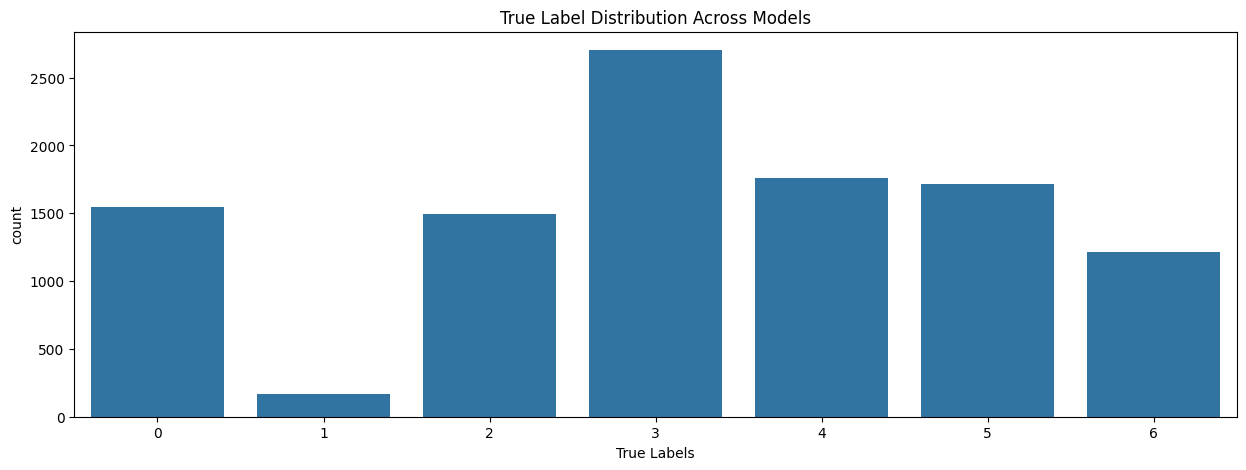

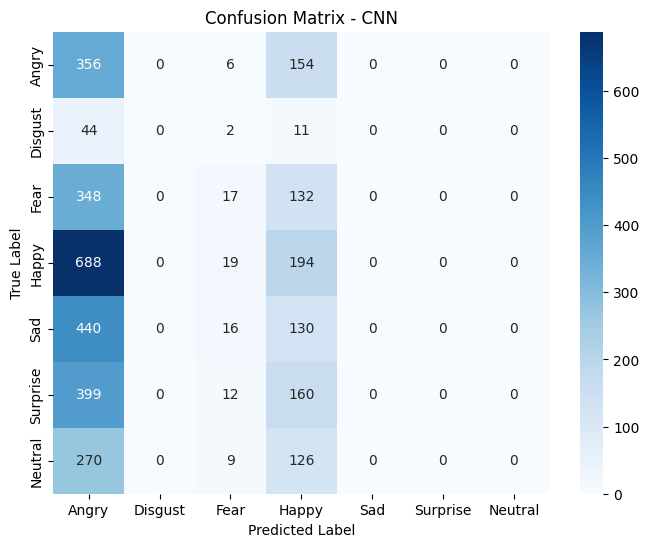

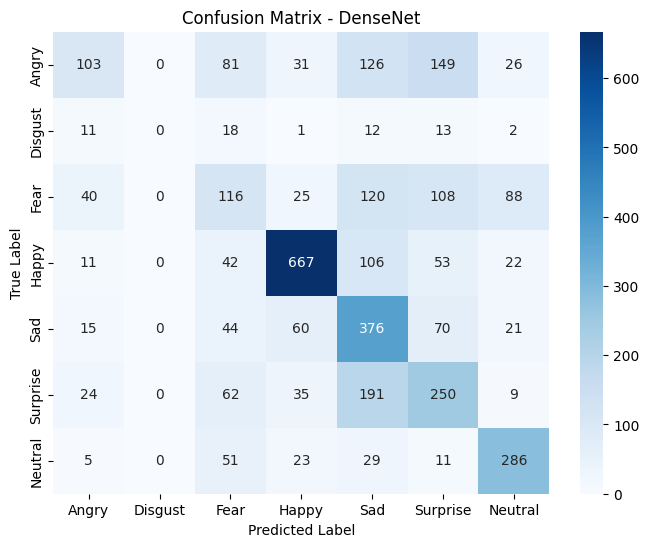

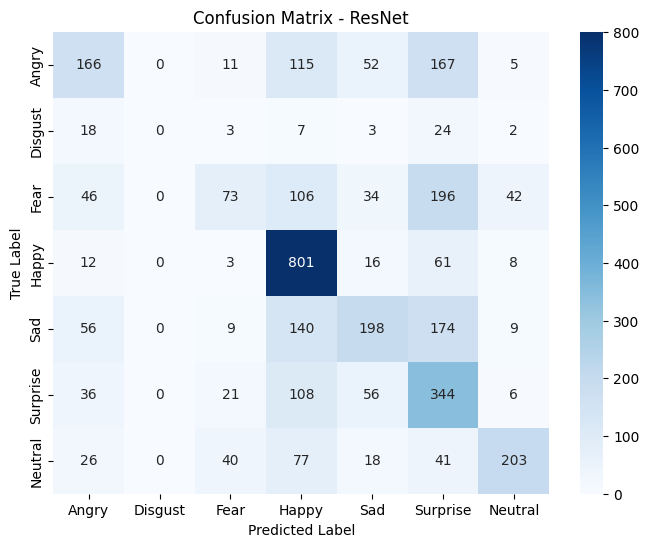

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Load the test results from CSV files
cnn_df = pd.read_csv('/content/drive/MyDrive/cnn_model_test_results.csv')
resnet_df = pd.read_csv('/content/drive/MyDrive/resnet_model_test_results.csv')
dense_df = pd.read_csv('/content/drive/MyDrive/desnse_model_test_results.csv')

# Concatenate the dataframes
combined_df = pd.concat([cnn_df, resnet_df, dense_df], keys=['CNN', 'ResNet', 'DenseNet'])

# Evaluate performance metrics
performance_metrics = pd.DataFrame()
for model_name, model_df in combined_df.groupby(level=0):
    report = classification_report(model_df['True Labels'], model_df['Predictions'], output_dict=True, zero_division=1)
    print(model_name)
    print(report)
    report_df = pd.DataFrame(report).transpose()
    performance_metrics = pd.concat([performance_metrics, report_df[['precision', 'recall', 'f1-score', 'support']]], axis=1, keys=[model_name])

# Plot performance metrics
plt.figure(figsize=(10, 5))
if 'f1-score' in performance_metrics.columns:
    sns.heatmap(performance_metrics.xs('f1-score', axis=1, level=1), annot=True, cmap='Blues')
    plt.title('F1-score Comparison')
    plt.show()
else:
    print("F1-score not available in the performance metrics.")

# Detect bias
plt.figure(figsize=(15, 5))
sns.countplot(data=combined_df, x='True Labels', hue=combined_df.index.names[0])
plt.title('True Label Distribution Across Models')
plt.show()

# Example: Confusion matrix
for model_name, model_df in combined_df.groupby(level=0):
    cm = confusion_matrix(model_df['True Labels'], model_df['Predictions'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], yticklabels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()



In [42]:
!pip install captum


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

Saliency Map for CNN Model


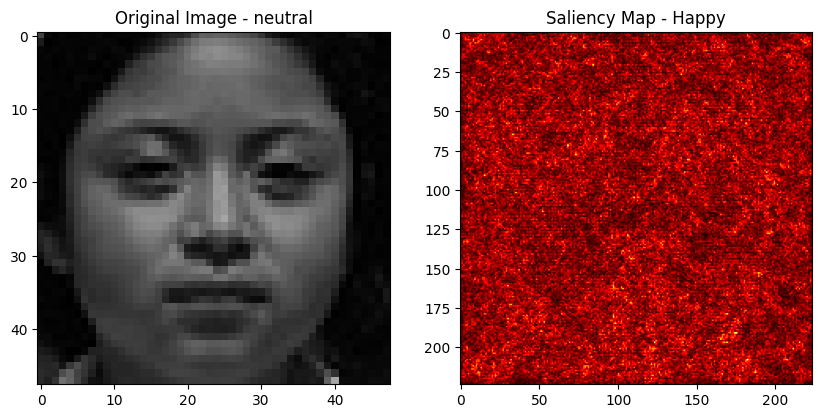

Saliency Map for ResNet Model


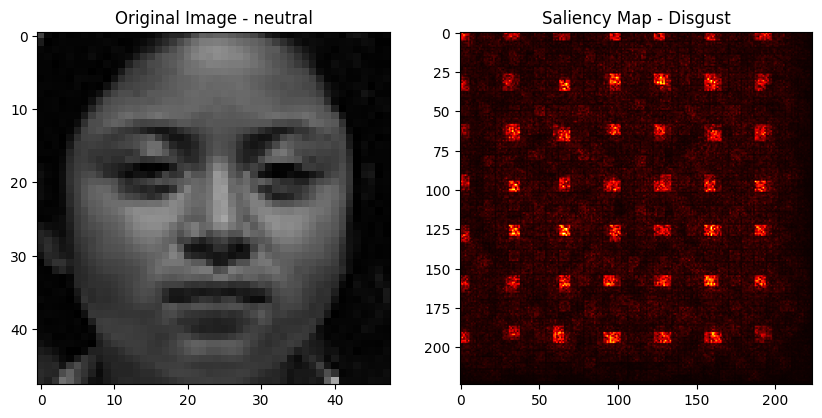

Saliency Map for DenseNet Model


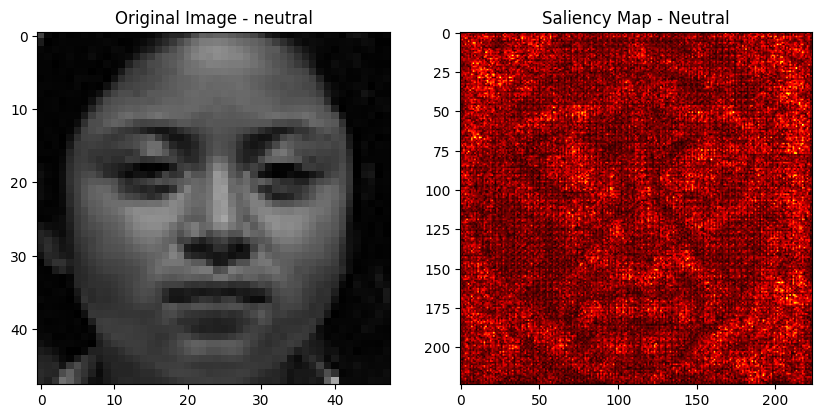

Saliency Map for CNN Model


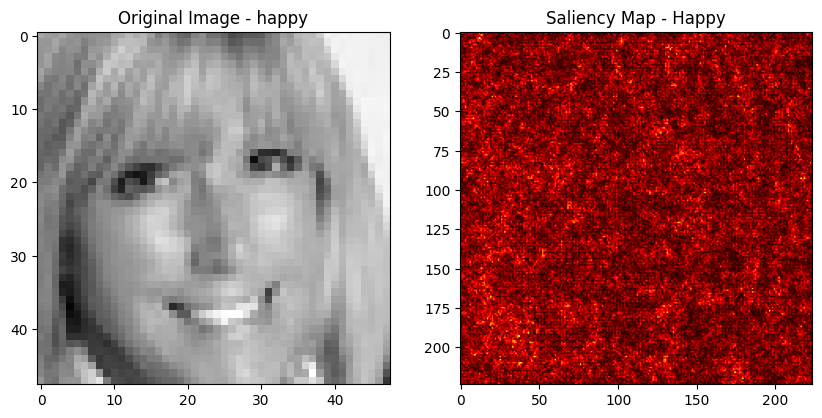

Saliency Map for ResNet Model


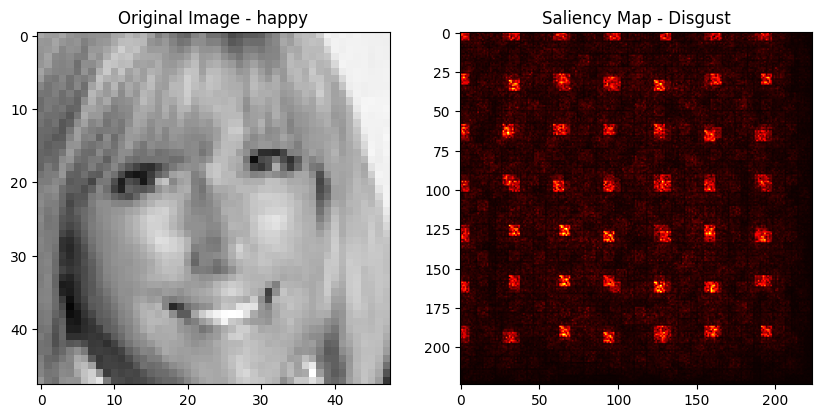

Saliency Map for DenseNet Model


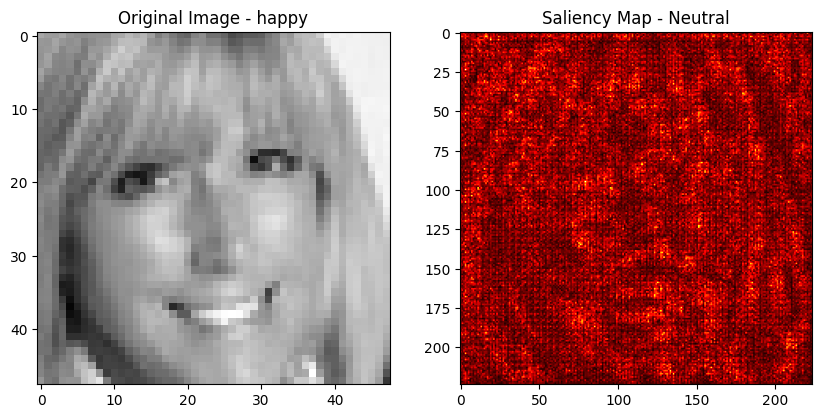

Saliency Map for CNN Model


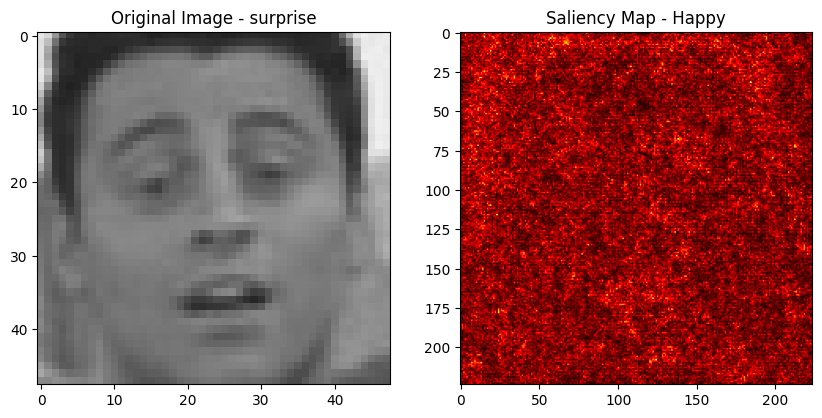

Saliency Map for ResNet Model


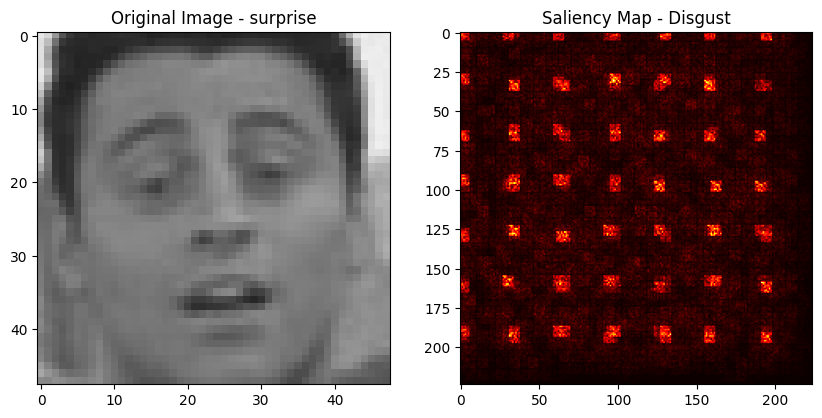

Saliency Map for DenseNet Model


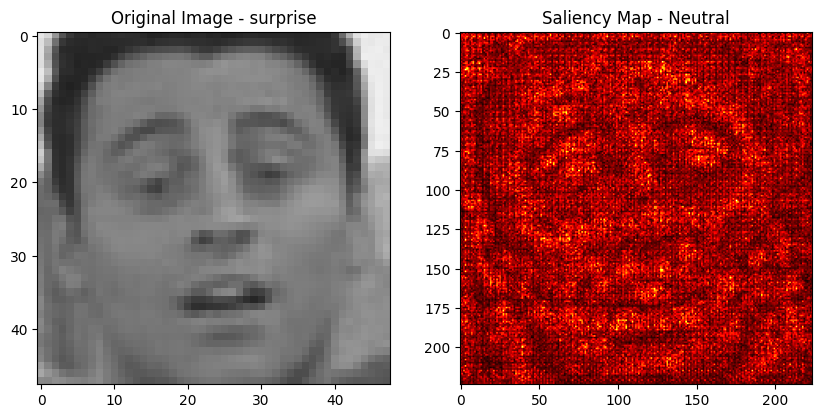

In [52]:
import pandas as pd
import numpy as np
import requests
from io import BytesIO
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the CNN model architecture
class CNNModel(nn.Module):
    def __init__(self, num_classes=7):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the CNN model
cnn_model = CNNModel(num_classes=7).to(DEVICE)

# Define the ResNet model architecture
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=7):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def make_layer(self, block, out_channels, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Instantiate the ResNet model
resnet_model = ResNet(BasicBlock, [2, 2, 2, 2]).to(DEVICE)

# Define the DenseNet model architecture
class DenseNet(nn.Module):
    def __init__(self, growth_rate=12, block_config=(6, 12, 24, 16), num_classes=7):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.features = self._make_dense_layers(block_config)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.in_channels, num_classes)

    def _make_dense_layers(self, block_config):
        layers = []
        for num_layers in block_config:
            layers.append(DenseBlock(self.in_channels, self.growth_rate, num_layers))
            self.in_channels += num_layers * self.growth_rate
            if num_layers != block_config[-1]:
                layers.append(TransitionBlock(self.in_channels, self.in_channels // 2))
                self.in_channels //= 2
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Instantiate the DenseNet model
dense_model = DenseNet().to(DEVICE)


# Define a function to load images from the local filesystem
def load_image(img_path):
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return img, img_tensor

def generate_saliency_map(model, img, img_tensor, label_names, true_label):
    # Move the input tensor to the appropriate device
    img_tensor = img_tensor.to(DEVICE)

    # Set the model to evaluation mode
    model.eval()

    # Make the input tensor require gradient
    img_tensor.requires_grad_()

    # Get the model's predictions
    output = model(img_tensor)
    pred_class = output.argmax(dim=1).item()

    # Get the loss and gradients
    model.zero_grad()
    loss = F.nll_loss(output, torch.tensor([pred_class]).to(DEVICE))
    loss.backward()

    # Get the gradients of the input image
    grads = img_tensor.grad.data.abs().max(dim=1)[0].squeeze().cpu().numpy()

    # Plot the saliency map
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image - {}'.format(true_label))

    plt.subplot(1, 2, 2)
    plt.imshow(grads, cmap='hot')
    plt.title('Saliency Map - {}'.format(label_names[pred_class]))

    plt.show()

# Example: Generate saliency maps for a few images from the CSV
num_images = 3  # Number of images to generate saliency maps for

for index, row in test_df.head(num_images).iterrows():
    img_path = row['image_path']
    img, img_tensor = load_image(img_path)
    true_label = row['label']  # Using 'label' to access the true labels

    print("Saliency Map for CNN Model")
    generate_saliency_map(cnn_model, img, img_tensor, label_names, true_label)

    print("Saliency Map for ResNet Model")
    generate_saliency_map(resnet_model, img, img_tensor, label_names, true_label)

    print("Saliency Map for DenseNet Model")
    generate_saliency_map(dense_model, img, img_tensor, label_names, true_label)




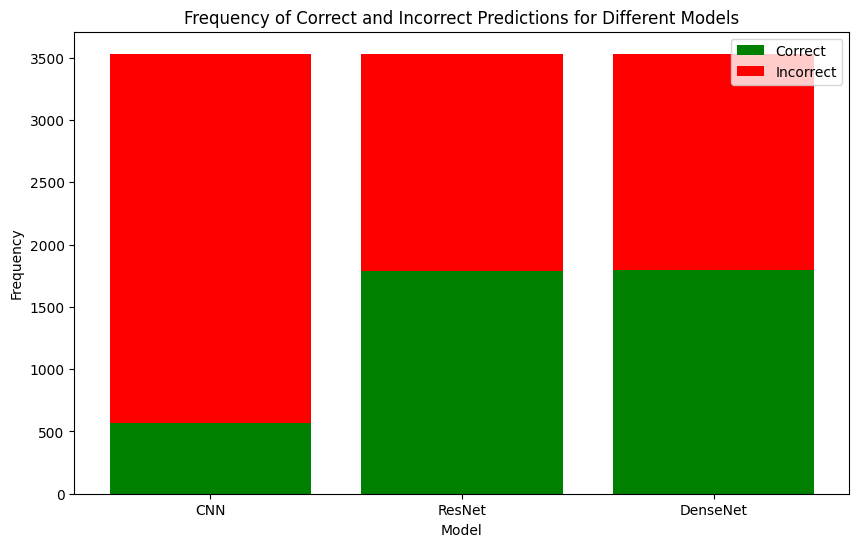

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the test results from CSV files
cnn_df = pd.read_csv('/content/drive/MyDrive/cnn_model_test_results.csv')
resnet_df = pd.read_csv('/content/drive/MyDrive/resnet_model_test_results.csv')
dense_df = pd.read_csv('/content/drive/MyDrive/desnse_model_test_results.csv')

# Calculate correctness of predictions
cnn_df['Correct'] = cnn_df['Predictions'] == cnn_df['True Labels']
resnet_df['Correct'] = resnet_df['Predictions'] == resnet_df['True Labels']
dense_df['Correct'] = dense_df['Predictions'] == dense_df['True Labels']

# Count correct and incorrect predictions for each model
cnn_correct = cnn_df['Correct'].sum()
cnn_incorrect = len(cnn_df) - cnn_correct

resnet_correct = resnet_df['Correct'].sum()
resnet_incorrect = len(resnet_df) - resnet_correct

dense_correct = dense_df['Correct'].sum()
dense_incorrect = len(dense_df) - dense_correct

# Plot the stacked bar chart
models = ['CNN', 'ResNet', 'DenseNet']
correct_predictions = [cnn_correct, resnet_correct, dense_correct]
incorrect_predictions = [cnn_incorrect, resnet_incorrect, dense_incorrect]

plt.figure(figsize=(10, 6))
plt.bar(models, correct_predictions, color='green', label='Correct')
plt.bar(models, incorrect_predictions, bottom=correct_predictions, color='red', label='Incorrect')

plt.xlabel('Model')
plt.ylabel('Frequency')
plt.title('Frequency of Correct and Incorrect Predictions for Different Models')
plt.legend()
plt.show()